This notebook contains all the code needed to generate a synthetic dataset.

Exits and funding are pulled from lognormal distr
Ordinal founder attrs come from discrete pdfs in hyperparameter config.

All params handled in `src/config.py` `SYNTH` variable.

Visualizations provided at the end to compare with expectations of real-world data.

Defining success as an exit or >5m in funding. compute a raw score (which could be used to prioritize) and probability of success in `model.ipynb`.

In [65]:
# ! pip install seaborn plotly scipy -q

In [66]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
import sys

sys.path.append('..')
from src.config import cfg
from src.scoring import one_hot_encode_column

In [67]:
MATRIX = cfg.MATRIX
POPULATIONS = cfg.SYNTH['POPULATIONS']
alpha = cfg.SYNTH['alpha']
beta = cfg.SYNTH['beta']
noise_std = cfg.SYNTH['noise_std']

K = sum(cfg['DIMENSION'] for cfg in MATRIX.values())
K

26

In [68]:
def sample_ordinal_for_category(cat, sampling_probs):
    d = MATRIX[cat]['DIMENSION']
    p = sampling_probs[cat]
    if d == 3:
        return np.random.choice([1,2,3], p=p)
    else:
        return np.random.choice([0,1,2,3], p=p)

def sample_exit_and_funding(
    p_fund, mu_fund, sig_fund,
    p_exit, mu_exit, sig_exit,
):

    if np.random.rand() < p_fund:
        funding_amt = np.random.lognormal(mu_fund, sig_fund)
        if np.random.rand() < p_exit:
            exit_val = np.random.lognormal(mu_exit, sig_exit)
        else:
            exit_val = 0
    else:
        funding_amt = 0
        exit_val = 0
    return exit_val, funding_amt

def generate_subpopulation(num_samples, pop_cfg, W_star):
    X_list, e_list, f_list = [], [], []
    for _ in range(num_samples):
        # Build the 26-d feature vector
        x_parts = []
        for cat in MATRIX:
            val = sample_ordinal_for_category(cat, pop_cfg["sampling_probs"])
            oh = one_hot_encode_column(val, MATRIX[cat]['DIMENSION'])
            x_parts.append(oh)
        x = np.concatenate(x_parts)
        
        e_val, f_val  = sample_exit_and_funding(
            pop_cfg["p_funding"], pop_cfg["mu_funding"], pop_cfg["sigma_funding"],
            pop_cfg["p_exit"],    pop_cfg["mu_exit"],    pop_cfg["sigma_exit"],
        )
        X_list.append(x)
        e_list.append(e_val)
        f_list.append(f_val)
    return np.array(X_list), np.array(e_list), np.array(f_list)

def generate_synthetic_dataset(total_samples, populations, seed=42):
    if seed is not None:
        np.random.seed(seed)
    K = sum(MATRIX[c]['DIMENSION'] for c in MATRIX)
    
    # Build W*
    W_star = np.zeros((K, K))
    start_idx = 0
    for cat in MATRIX:
        w = MATRIX[cat]['WEIGHT']
        dim = MATRIX[cat]['DIMENSION']
        end_idx = start_idx + dim
        tiers = np.array(list(range(3, 3-dim, -1))[::-1]) * w
        W_star[np.arange(start_idx, end_idx),
               np.arange(start_idx, end_idx)] = tiers
        start_idx = end_idx
    
    # Add small random noise off-diagonal
    noise = np.random.normal(0, 0.005, (K, K))
    np.fill_diagonal(noise, 0)
    W_star += noise
    W_star = 0.5*(W_star + W_star.T)
    
    X_all, e_all, f_all = [], [], []
    labels = []
    for pop_name, pop_cfg in populations.items():
        n_sub = int(round(pop_cfg["fraction"] * total_samples))
        X_sub, e_sub, f_sub = generate_subpopulation(n_sub, pop_cfg, W_star)
        X_all.append(X_sub)
        e_all.append(e_sub)
        f_all.append(f_sub)
        labels += [pop_name]*n_sub
    
    X_final = np.vstack(X_all)
    exit_final = np.concatenate(e_all)
    fund_final = np.concatenate(f_all)
    labels = np.array(labels[:len(exit_final)])
    
    return X_final, exit_final, fund_final, labels, W_star

In [69]:
def get_category_slice(category_name):
    start = 0
    for cat in MATRIX:
        d = MATRIX[cat]['DIMENSION']
        if cat == category_name:
            return slice(start, start+d)
        start += d
    return slice(0, 0)  # fallback

def plot_category_distribution_overall_and_by_pop(X, pop_labels, category_name):
    cat_slice = get_category_slice(category_name)
    d = MATRIX[category_name]['DIMENSION']
    
    cat_indices = X[:, cat_slice].argmax(axis=1)  # 0..(d-1)
    
    counts = np.bincount(cat_indices, minlength=d)
    
    plt.figure(figsize=(8,5))
    bars = plt.bar(range(d), counts, color='cornflowerblue', edgecolor='black')
    plt.title(f"Overall Distribution of {category_name} (tiers=0..{d-1})", fontsize=14)
    plt.xlabel("Tier Index", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    unique_pops = np.unique(pop_labels)
    plt.figure(figsize=(10,6))
    width = 0.8 / len(unique_pops)
    
    pop_percentages = {}
    for pop_name in unique_pops:
        pop_mask = (pop_labels == pop_name)
        cat_pop_indices = cat_indices[pop_mask]
        ccounts = np.bincount(cat_pop_indices, minlength=d)
        pop_percentages[pop_name] = 100.0 * ccounts / ccounts.sum()
    
    for i, pop_name in enumerate(unique_pops):
        pop_mask = (pop_labels == pop_name)
        x_positions = np.arange(d) + (i - len(unique_pops)/2)*width + width/2
        bars = plt.bar(x_positions, pop_percentages[pop_name], 
                       width=width, label=f"{pop_name} (n={pop_mask.sum()})")

        for bar in bars:
            height = bar.get_height()
            if height > 5: 
                plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                         f'{height:.1f}%', ha='center', va='bottom', fontsize=8)
    
    plt.title(f"{category_name} Tier Distribution by Population (%)", fontsize=14)
    plt.xlabel("Tier Index", fontsize=12)
    plt.ylabel("Percentage within Population", fontsize=12)
    plt.xticks(np.arange(d), [str(i) for i in range(d)])
    plt.legend(loc='best')
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

def plot_hist_overall_and_by_pop(values, pop_labels, title, bins=50, log_scale=False):
    bins = int(bins)
    
    if log_scale:
        raw_vals = values
        plot_vals = np.log1p(values)  
        xlabel_str = f"{title} [log(1 + x)]"
    else:
        raw_vals = values
        plot_vals = values
        xlabel_str = title
    
    plt.figure(figsize=(9,5))
    
    min_val, max_val = plot_vals.min(), plot_vals.max()
    bin_edges = np.linspace(min_val, max_val, bins)
    
    n, bin_edges, patches = plt.hist(plot_vals, bins=bin_edges,
                                     color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(f"{title} - Overall Distribution", fontsize=14)
    plt.xlabel(xlabel_str, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    
    stats_text = (f"Mean: {raw_vals.mean():.2f}\n"
                  f"Median: {np.median(raw_vals):.2f}\n"
                  f"Std: {raw_vals.std():.2f}")
    plt.annotate(stats_text, xy=(0.70, 0.75), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8))
    
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()
  
    unique_pops = np.unique(pop_labels)
    plt.figure(figsize=(10,6))
    
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_pops)))
    
    for i, pop_name in enumerate(unique_pops):
        mask = (pop_labels == pop_name)
        sub_vals_raw = raw_vals[mask]
        sub_vals_log = plot_vals[mask]  
        
        label_str = (f"{pop_name} (n={mask.sum()}, "
                     f"mean={sub_vals_raw.mean():.2f}, "
                     f"std={sub_vals_raw.std():.2f})")
        
        plt.hist(sub_vals_log, bins=bin_edges, alpha=0.6,
                 label=label_str, color=colors[i])
    
    plt.xlabel(xlabel_str, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.title(f"{title} by Population", fontsize=14)
    plt.legend(loc='best')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,6))
    
    for i, pop_name in enumerate(unique_pops):
        mask = (pop_labels == pop_name)
        sub_vals_raw = raw_vals[mask]
        sub_vals_log = plot_vals[mask]
        
        if len(sub_vals_log) > 1:
            kde = stats.gaussian_kde(sub_vals_log)
            x_eval = np.linspace(sub_vals_log.min(), sub_vals_log.max(), 500)
            density = kde(x_eval)
            
            label_str = f"{pop_name} (mean={sub_vals_raw.mean():.2f})"
            plt.plot(x_eval, density, label=label_str,
                     color=colors[i], linewidth=2)
    
    plt.xlabel(xlabel_str, fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.title(f"{title} Density by Population (KDE)", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

def plot_scatter_overall_and_by_pop(xvals, yvals, pop_labels, x_title, y_title, log_y=False):
    plt.figure(figsize=(10,7))
    unique_pops = np.unique(pop_labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_pops)))
    
    for i, pop_name in enumerate(unique_pops):
        mask = (pop_labels == pop_name)
        x_pop = xvals[mask]
        y_pop = yvals[mask]
        
        plt.scatter(x_pop, y_pop, alpha=0.5, label=pop_name, color=colors[i])
        
        if len(x_pop) > 3:
            if log_y:
                log_y_pop = np.log(y_pop)
                z = np.polyfit(x_pop, log_y_pop, 1)
                p = np.poly1d(z)
                x_range = np.linspace(x_pop.min(), x_pop.max(), 50)
                plt.plot(x_range, np.exp(p(x_range)), '--', color=colors[i], 
                         linewidth=2, alpha=0.7)
            else:
                z = np.polyfit(x_pop, y_pop, 1)
                p = np.poly1d(z)
                x_range = np.linspace(x_pop.min(), x_pop.max(), 50)
                plt.plot(x_range, p(x_range), '--', color=colors[i], 
                         linewidth=2, alpha=0.7)
    
    if log_y:
        plt.yscale('log')
    
    plt.xlim(left=0)
    
    plt.title(f"{x_title} vs. {y_title} by Population", fontsize=14)
    plt.xlabel(x_title, fontsize=12)
    plt.ylabel(y_title + (" [log scale]" if log_y else ""), fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

def plot_feature_importance(W_star):
    feature_importance = np.sum(np.abs(W_star), axis=0)
    
    feature_names = []
    for cat_name in MATRIX:
        dim = MATRIX[cat_name]['DIMENSION']
        for i in range(dim):
            feature_names.append(f"{cat_name}_{i}")
    
    sorted_indices = np.argsort(feature_importance)[::-1]
    sorted_imp = feature_importance[sorted_indices]
    sorted_names = [feature_names[i] for i in sorted_indices]
    
    top_k = min(15, len(sorted_names))
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(top_k), sorted_imp[:top_k], color='teal')
    plt.xticks(range(top_k), sorted_names[:top_k], rotation=45, ha='right')
    plt.title('Top Feature Importance (from W*)', fontsize=14)
    plt.xlabel('Feature', fontsize=12)
    plt.ylabel('Importance Score', fontsize=12)
    
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f"{height:.2f}", ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(X, y, exit_vals, fund_vals, feature_names=None):
    if feature_names is None:
        feature_names = []
        for cat_name in MATRIX:
            d = MATRIX[cat_name]['DIMENSION']
            for i in range(d):
                feature_names.append(f"{cat_name}_{i}")
    
    data = np.column_stack([X, y, exit_vals, fund_vals])
    col_names = feature_names + ['Score', 'Exit', 'Funding']
    df = pd.DataFrame(data, columns=col_names)
    
    corr = df.corr()
    
    plt.figure(figsize=(12, 10))
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
                annot=True, fmt=".2f")
    plt.title('Correlation Heatmap: Features & Targets', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    target_cols = ['Score','Exit','Funding']
    target_corr = corr.loc[target_cols, target_cols]
    plt.figure(figsize=(6, 5))
    sns.heatmap(target_corr, cmap=cmap, center=0, square=True,
                linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")
    plt.title('Correlation among Targets', fontsize=14)
    plt.tight_layout()
    plt.show()

def print_funding_exit_stats(fund_vals, exit_vals, label="Overall"):
    df = pd.DataFrame({'Funding': fund_vals, 'Exit': exit_vals})
    
    print(f"----- {label} Summary -----")
    print("Funding Stats (in $):")
    print(df['Funding'].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]))
    print("\nExit Stats (in $):")
    print(df['Exit'].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]))
    print("\n")
    

def visualize_successful_cases(exit_vals, fund_vals):
    funding_success_mask = fund_vals > 5_000_000
    exit_success_mask = exit_vals > 0
    both_success_mask = funding_success_mask & exit_success_mask
    unsuccessful_mask = ~(funding_success_mask | exit_success_mask)
    
    num_funding_success = np.sum(funding_success_mask)
    num_exit_success = np.sum(exit_success_mask)
    num_both_success = np.sum(both_success_mask)
    num_unsuccessful = np.sum(unsuccessful_mask)
    
    # Print the counts
    print(f"Funding > $5M: {num_funding_success}")
    print(f"Exit > 0: {num_exit_success}")
    print(f"Both Funding > $5M and Exit > 0: {num_both_success}")
    print(f"Unsuccessful: {num_unsuccessful}")
    
    # Plot
    categories = ['Funding > $5M', 'Exit > 0', 'Both', 'Unsuccessful']
    counts = [num_funding_success, num_exit_success, num_both_success, num_unsuccessful]
    
    plt.figure(figsize=(8, 5))
    plt.bar(categories, counts, color=['teal', 'orange', 'purple', 'grey'])
    plt.title('Number of Successful vs Unsuccessful Cases', fontsize=14)
    plt.xlabel('Category', fontsize=12)
    plt.ylabel('Number of Cases', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [70]:
N = 10000
X_syn, exit_syn, fund_syn, pop_labels, W_star = generate_synthetic_dataset(N, POPULATIONS)

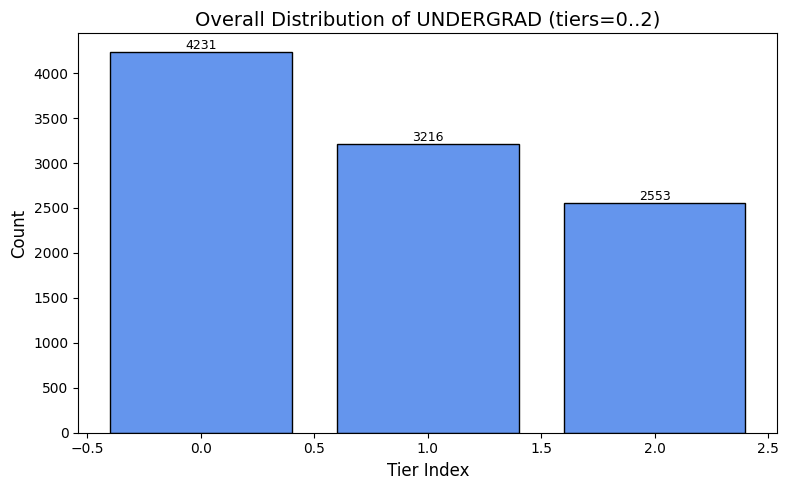

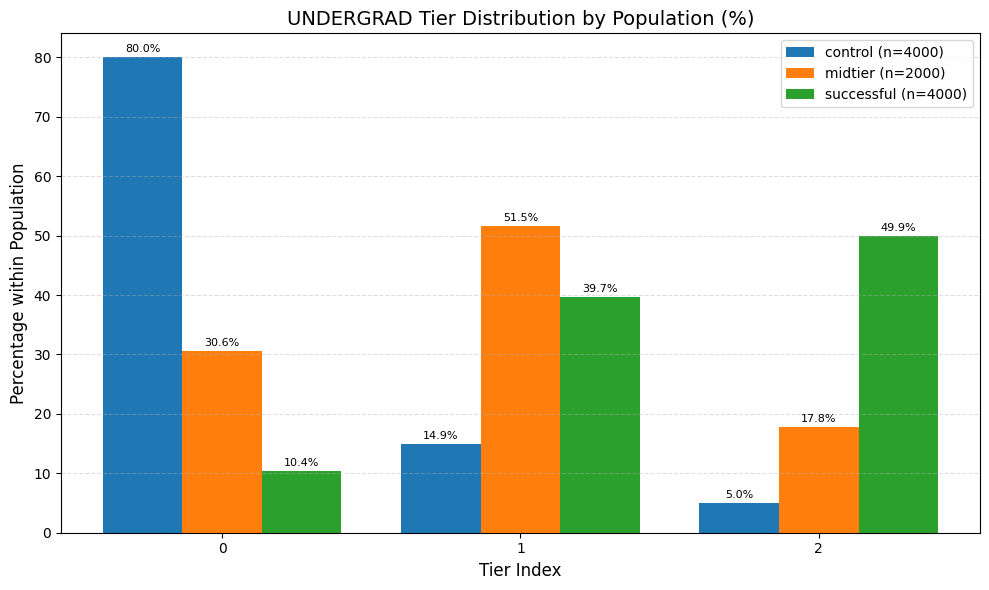

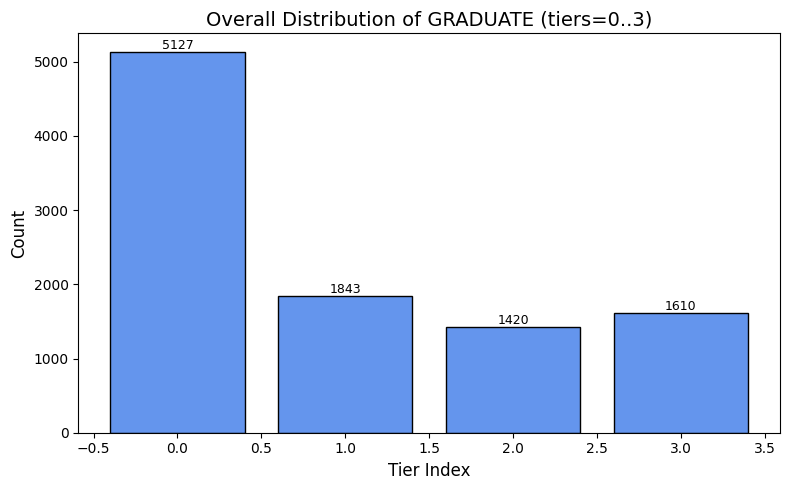

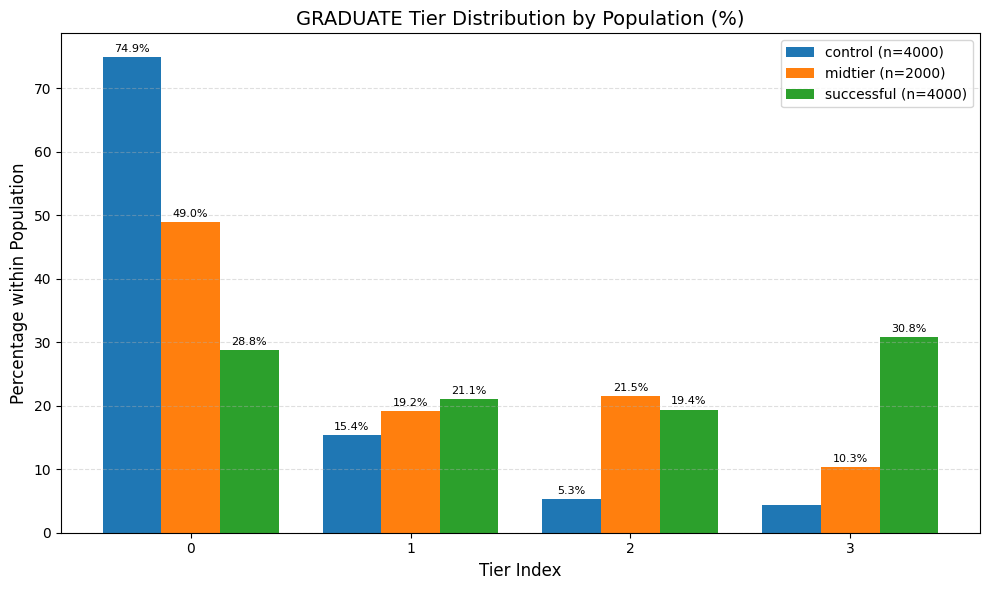

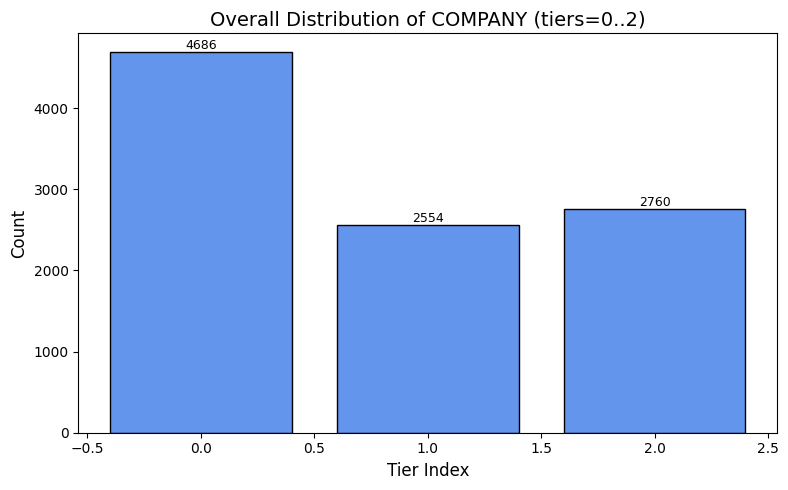

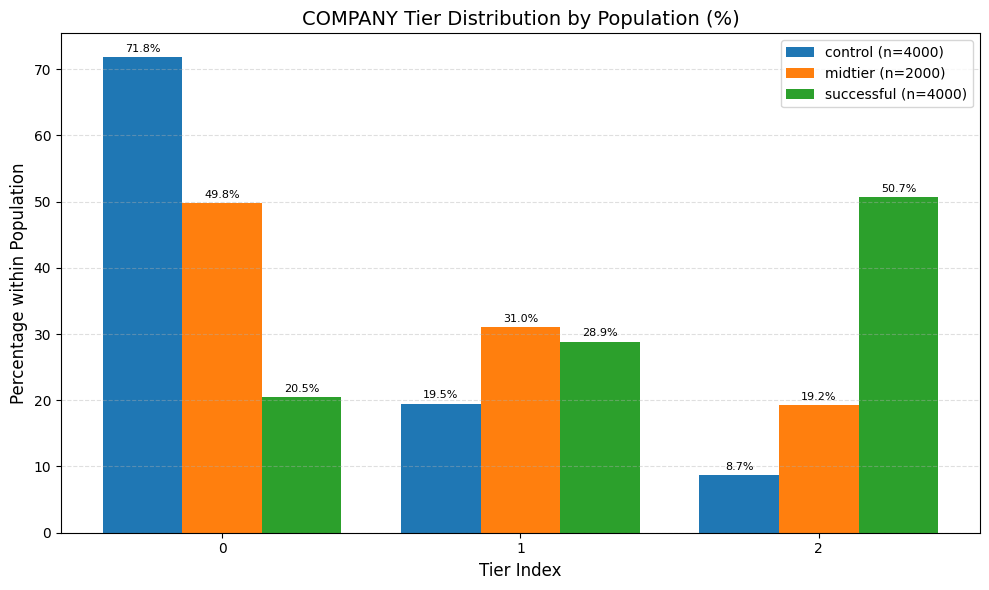

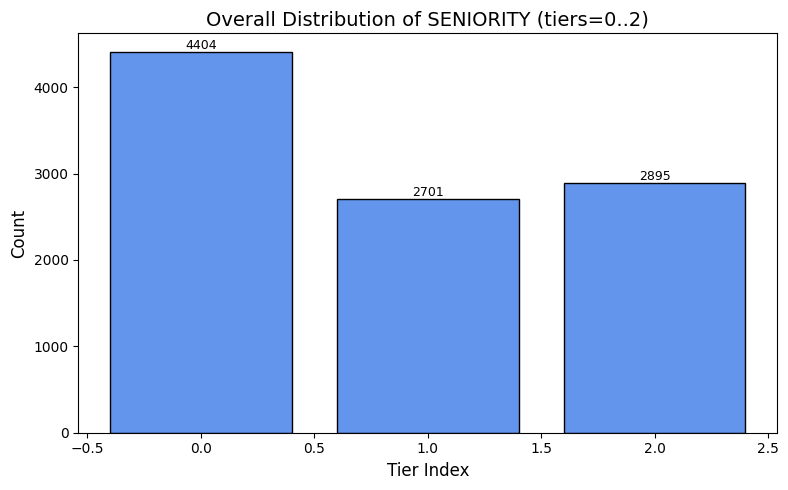

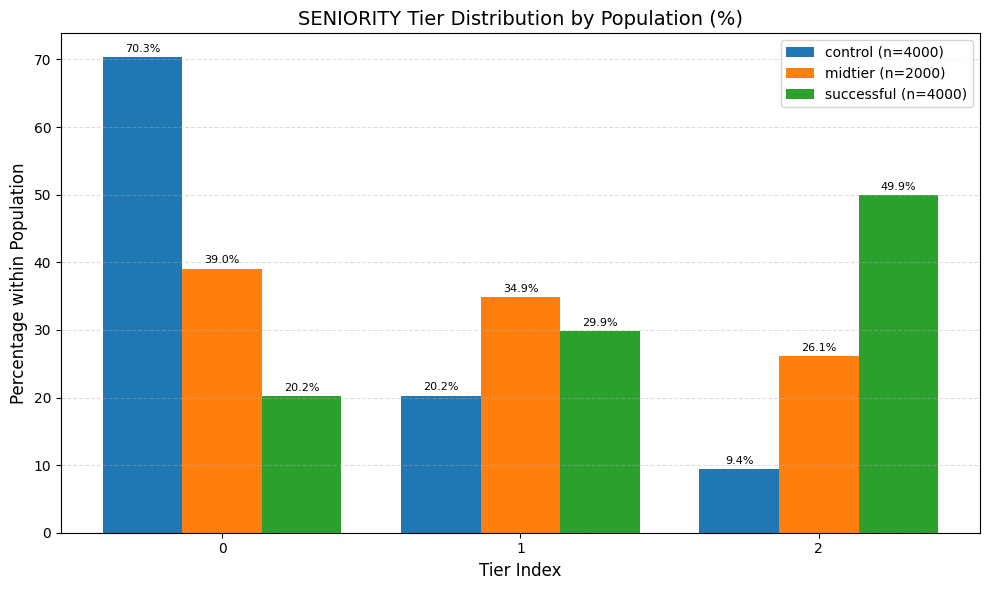

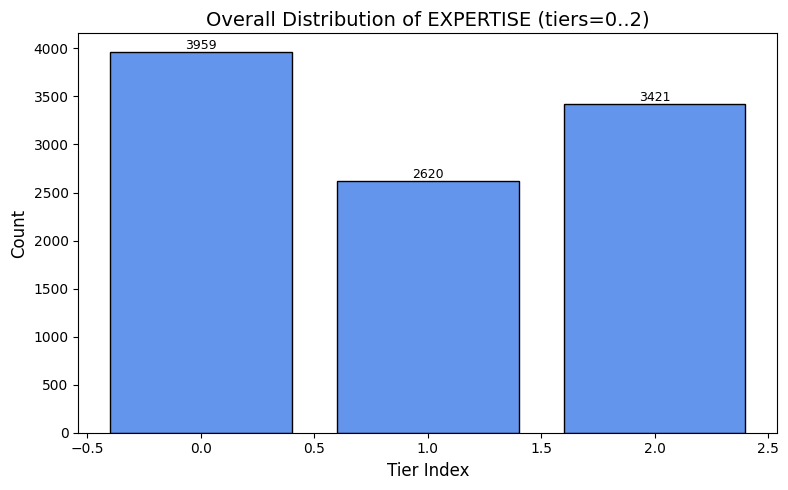

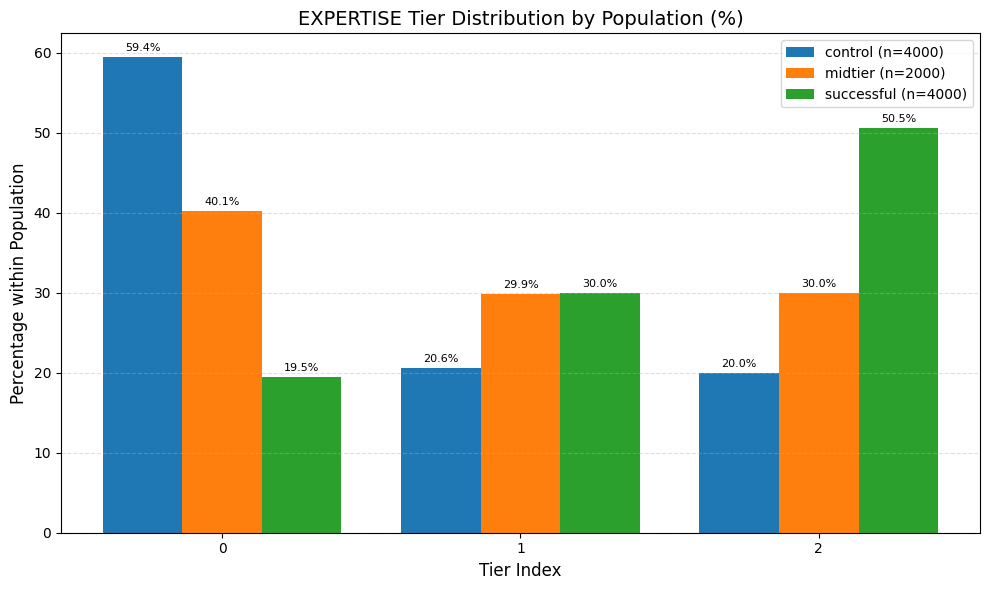

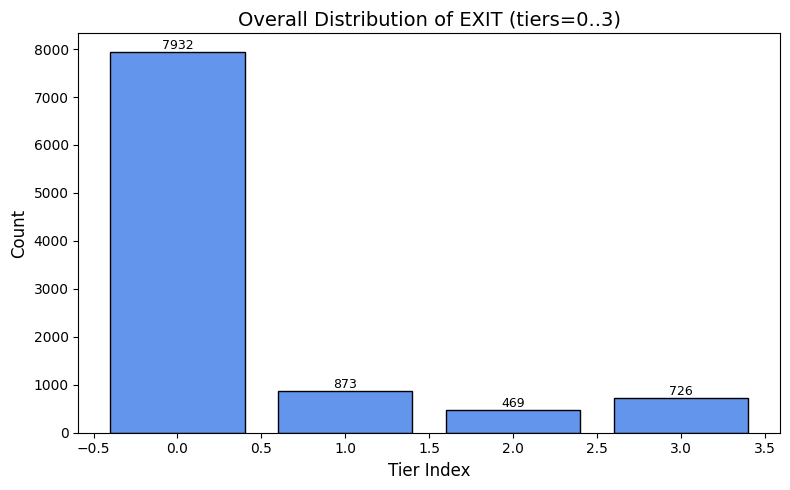

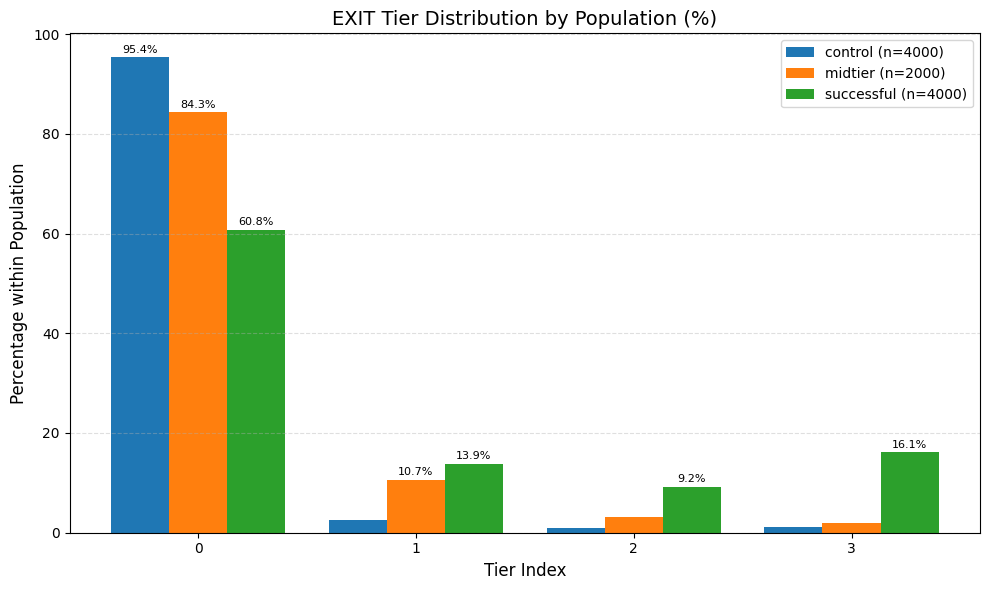

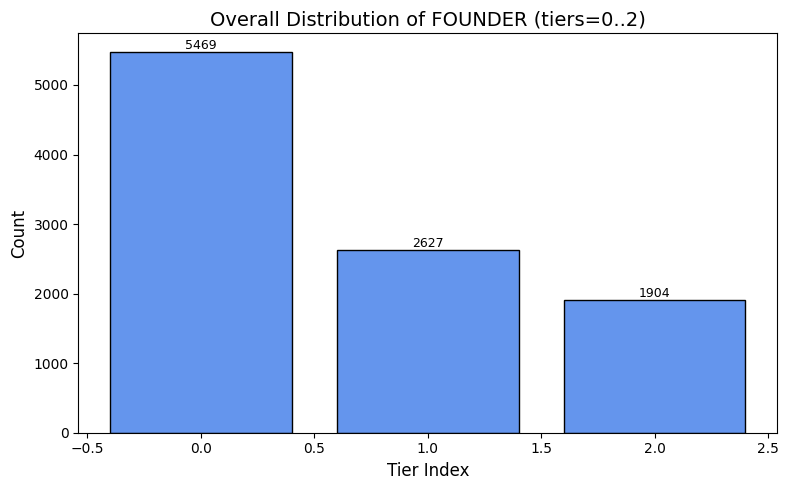

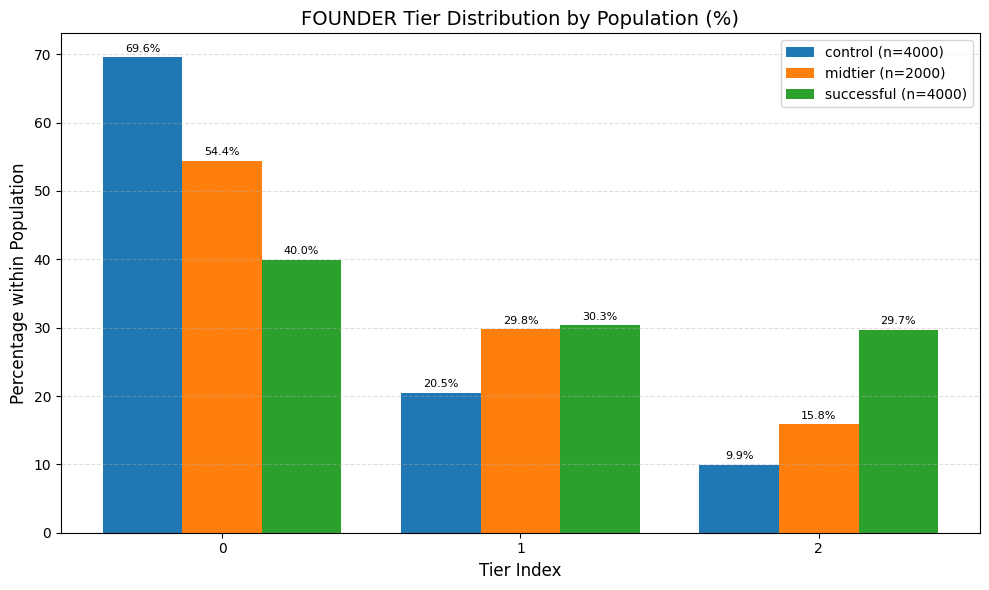

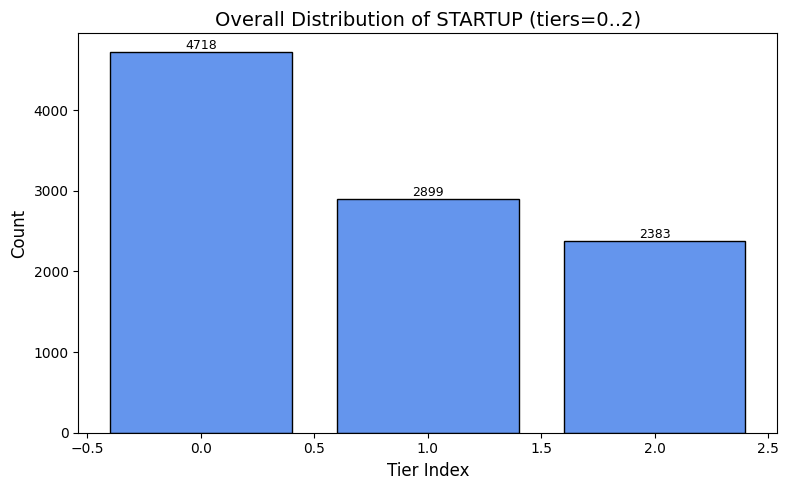

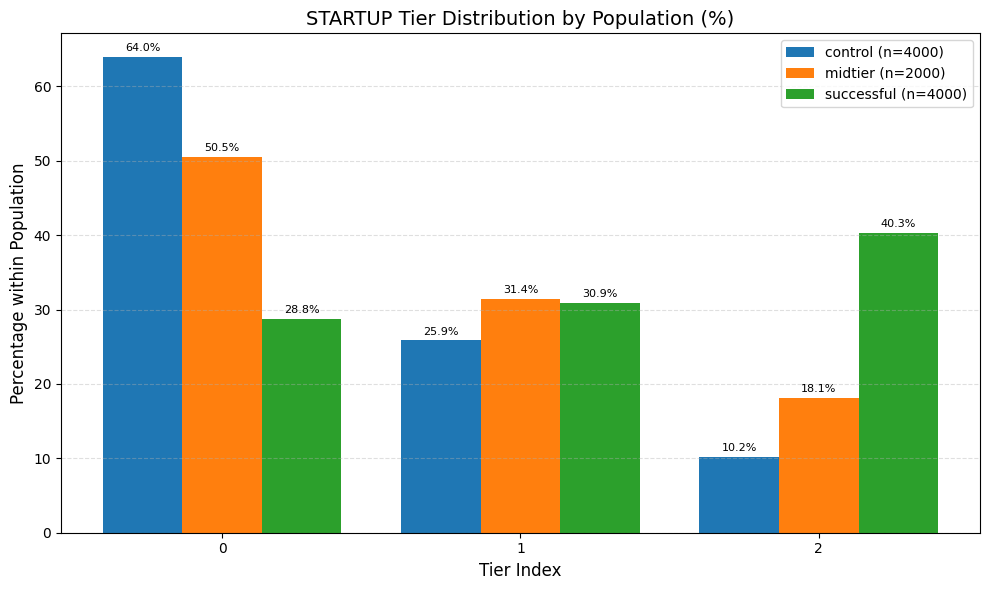

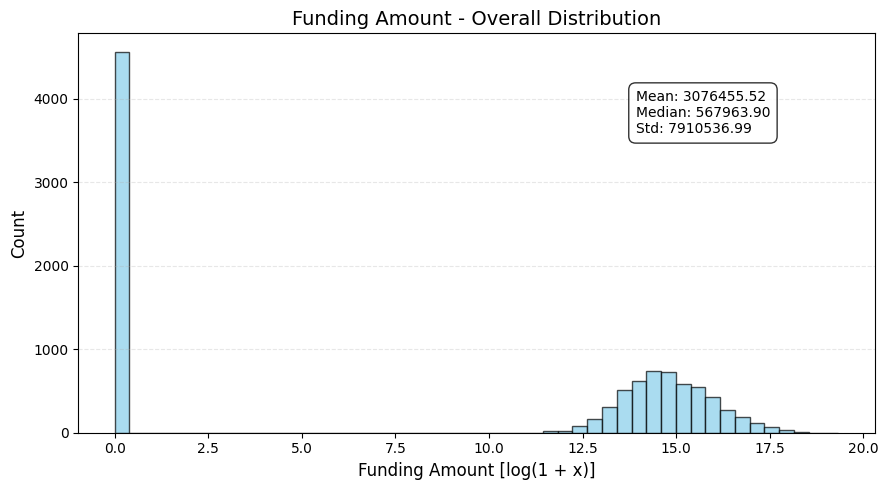

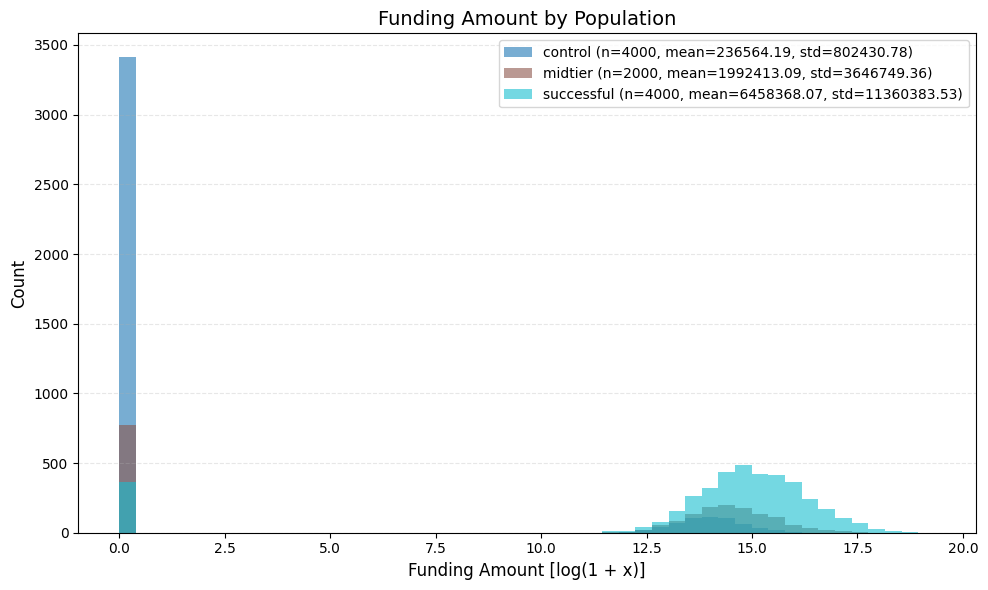

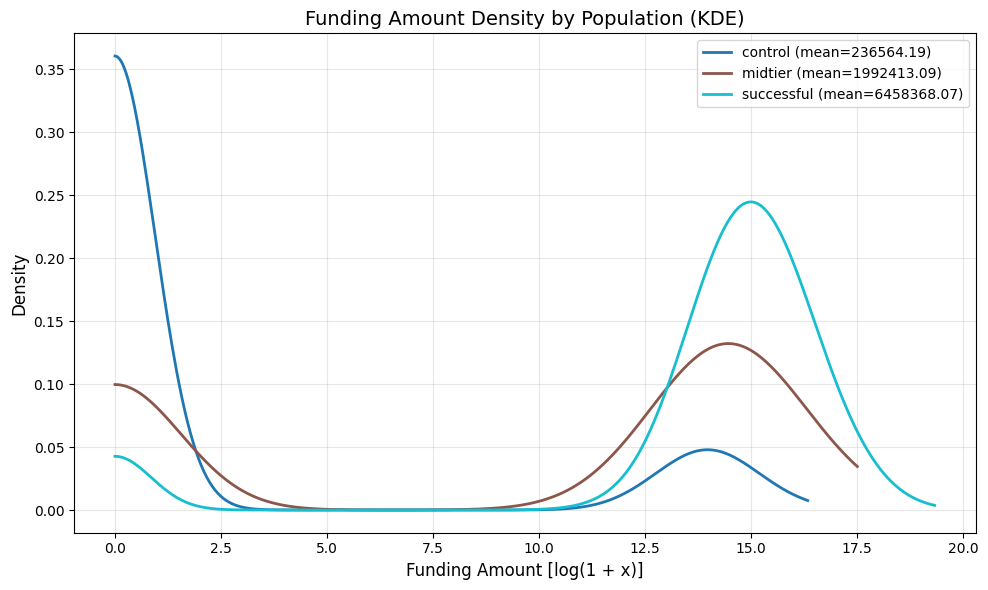

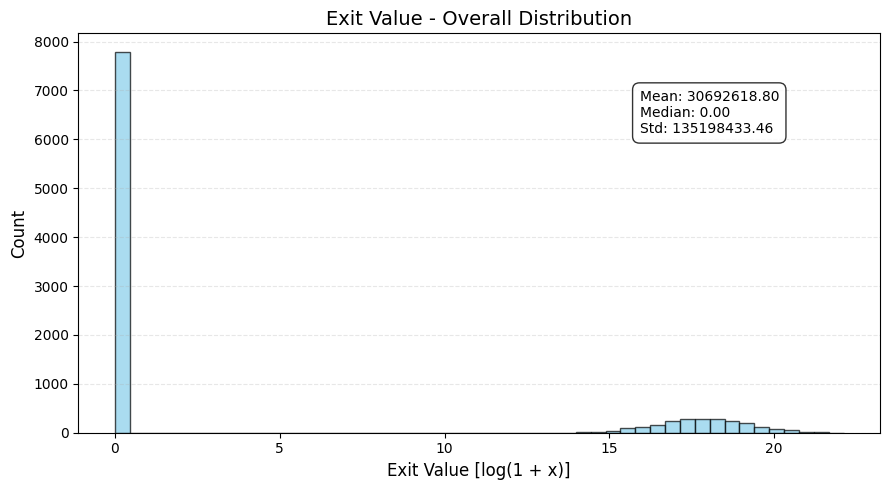

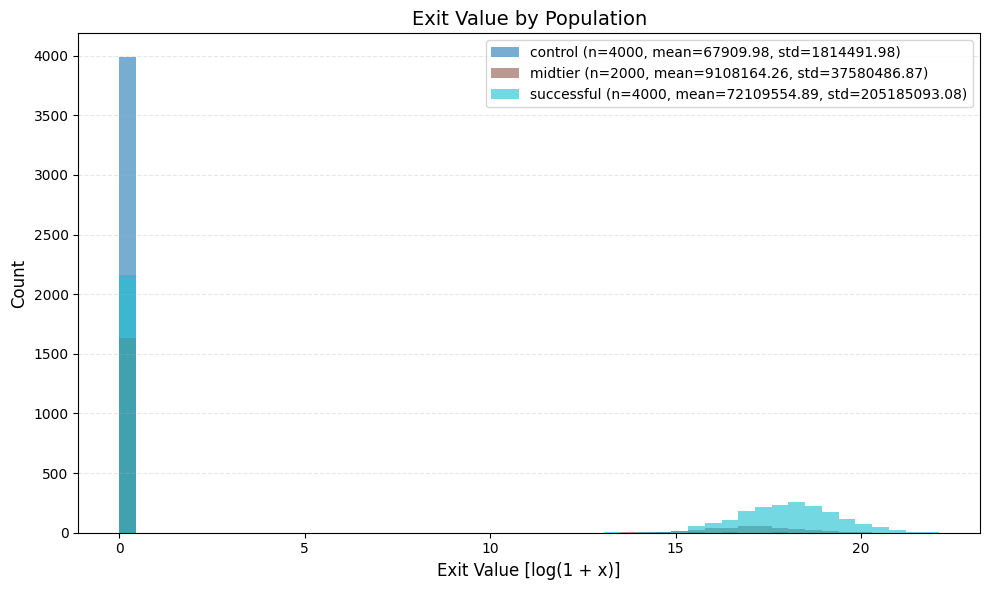

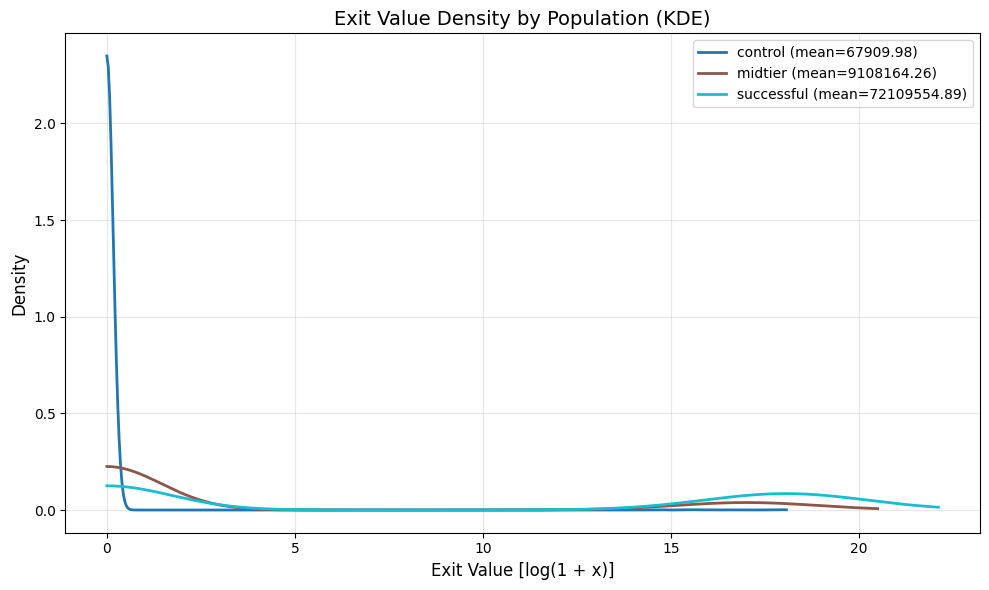

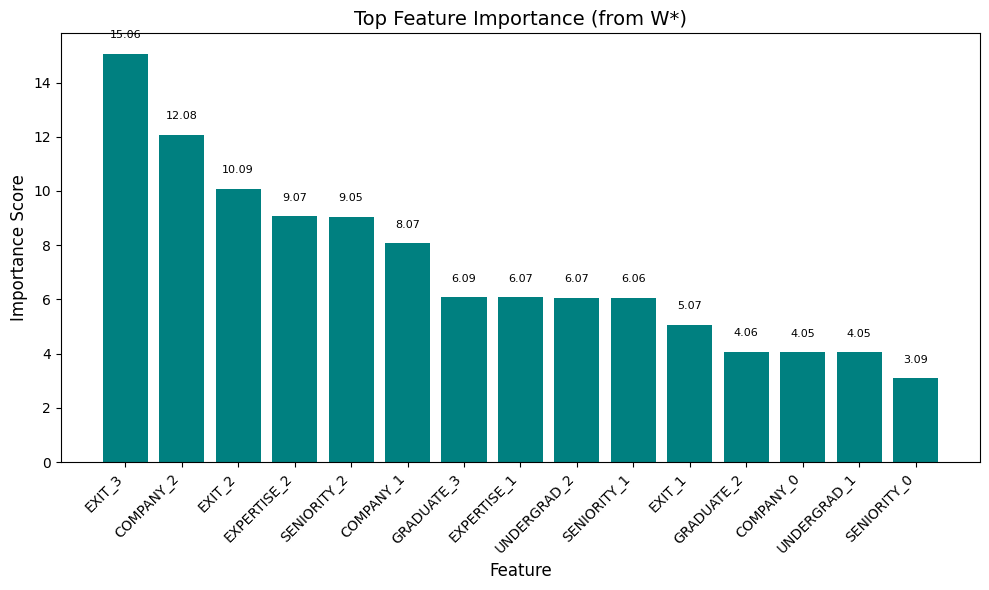

----- Overall Summary -----
Funding Stats (in $):
count    1.000000e+04
mean     3.076456e+06
std      7.910933e+06
min      0.000000e+00
1%       0.000000e+00
5%       0.000000e+00
25%      0.000000e+00
50%      5.679639e+05
75%      2.825326e+06
95%      1.339855e+07
99%      3.768138e+07
max      2.491636e+08
Name: Funding, dtype: float64

Exit Stats (in $):
count    1.000000e+04
mean     3.069262e+07
std      1.352052e+08
min      0.000000e+00
1%       0.000000e+00
5%       0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
95%      1.589529e+08
99%      5.436356e+08
max      3.982210e+09
Name: Exit, dtype: float64


Funding > $5M: 1608
Exit > 0: 2221
Both Funding > $5M and Exit > 0: 744
Unsuccessful: 6915


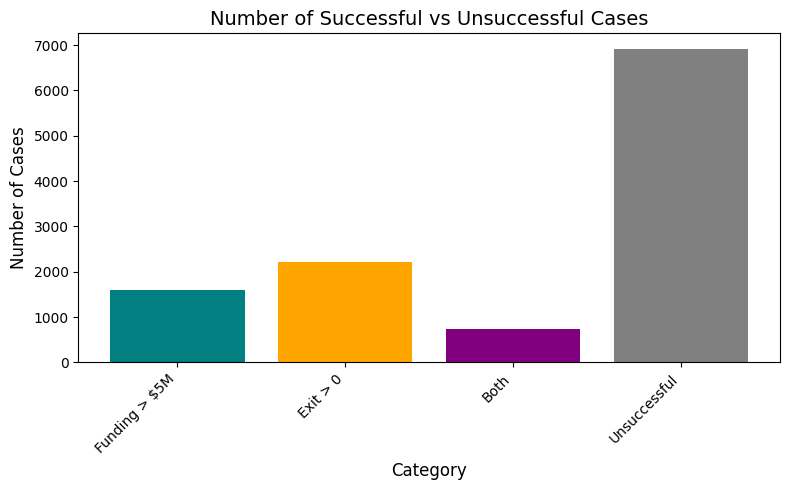

In [71]:
for cat_name in MATRIX.keys():
    plot_category_distribution_overall_and_by_pop(X_syn, pop_labels, cat_name)

plot_hist_overall_and_by_pop(fund_syn, pop_labels, title="Funding Amount", bins=50, log_scale=True)

plot_hist_overall_and_by_pop(exit_syn, pop_labels, title="Exit Value", bins=50, log_scale=True)

plot_feature_importance(W_star)

print_funding_exit_stats(fund_syn, exit_syn, label="Overall")

visualize_successful_cases(exit_syn, fund_syn)


In [72]:
feature_names = []
for cat in MATRIX:
    dim = MATRIX[cat]['DIMENSION']
    for i in range(dim):
        if dim == 3:
            feature_names.append(f"{cat}_{i + 1}") 
        else:
            feature_names.append(f"{cat}_{i}")

df = pd.DataFrame(X_syn, columns=feature_names)
df["exit_value"] = exit_syn
df["funding_amount"] = fund_syn

df['success'] = ((df['exit_value'] > 0) | (df['funding_amount'] > 5_000_000)).astype(int)


df.to_csv("../data/synth/encoded_founders_composites.csv", index=False)
df


,UNDERGRAD_1,UNDERGRAD_2,UNDERGRAD_3,GRADUATE_0,GRADUATE_1,GRADUATE_2,GRADUATE_3,COMPANY_1,COMPANY_2,COMPANY_3,...,EXIT_3,FOUNDER_1,FOUNDER_2,FOUNDER_3,STARTUP_1,STARTUP_2,STARTUP_3,exit_value,funding_amount,success
0,0,0,1,0,1,0,0,1,0,0,...,0,1,0,0,1,0,0,5.542555e+07,3.680264e+06,1
1,0,0,1,1,0,0,0,1,0,0,...,1,0,0,1,0,1,0,0.000000e+00,1.485586e+06,0
2,1,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,1,2.628091e+07,1.061478e+06,1
3,0,0,1,1,0,0,0,0,0,1,...,0,1,0,0,0,0,1,6.252487e+07,6.031049e+05,1
4,0,0,1,0,0,0,1,0,1,0,...,0,0,1,0,1,0,0,0.000000e+00,1.228589e+07,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,0,0,1,0,0,0,0,0,1,...,0,0,1,0,1,0,0,0.000000e+00,0.000000e+00,0
9996,1,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0.000000e+00,0.000000e+00,0
9997,1,0,0,1,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0.000000e+00,0.000000e+00,0
9998,1,0,0,1,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0.000000e+00,0.000000e+00,0
